In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 20,10 ## дюймы

In [ ]:
def equation(x):
    return 1032,41/(1+x)**(68/365) - 985,6

In [ ]:
def solve_equation():
    # Исходные значения для начала и конца отрезка
    a = 0,11
    b = 0,15

    # Проверка на то, что функция меняет знак на отрезке
    if equation(a) * equation(b) >= 0:
        print("Уравнение не имеет решений на данном отрезке.")
        return None

# Точность решения
    epsilon = 0.00001

    # Основной цикл метода бисекции
    while abs(b - a) > epsilon:
        mid = (a + b) / 2
        if equation(mid) == 0:
            return mid
        elif equation(mid) * equation(a) < 0:
            b = mid
        else:
            a = mid
    return (a + b) / 2

result = solve_equation()
print("Результат:", result)

TypeError: ignored

# <center> Matplotlib

Matplotlib – одна из самых популярных библиотек Python для визуализации данных.

Импорт: import matplotlib.pyplot as plt

Документация: https://matplotlib.org/contents.html

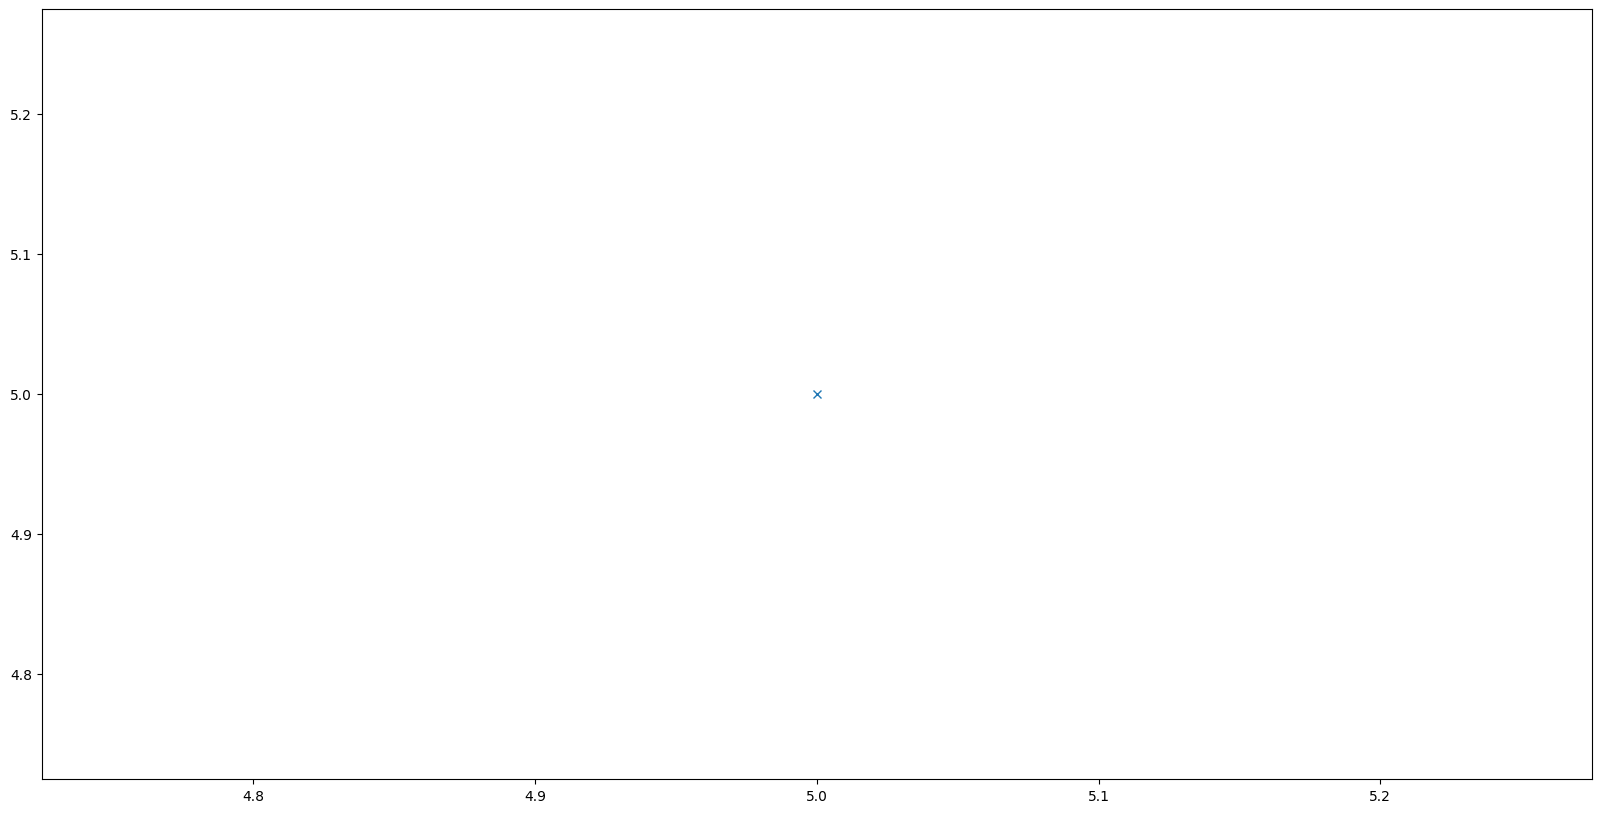

In [ ]:
# первый позиционный аргумент – точки по Y, второй – точки по X. По умолчанию это единичные отрезки
plt.plot(5, 5, 'x')
#plt.show()

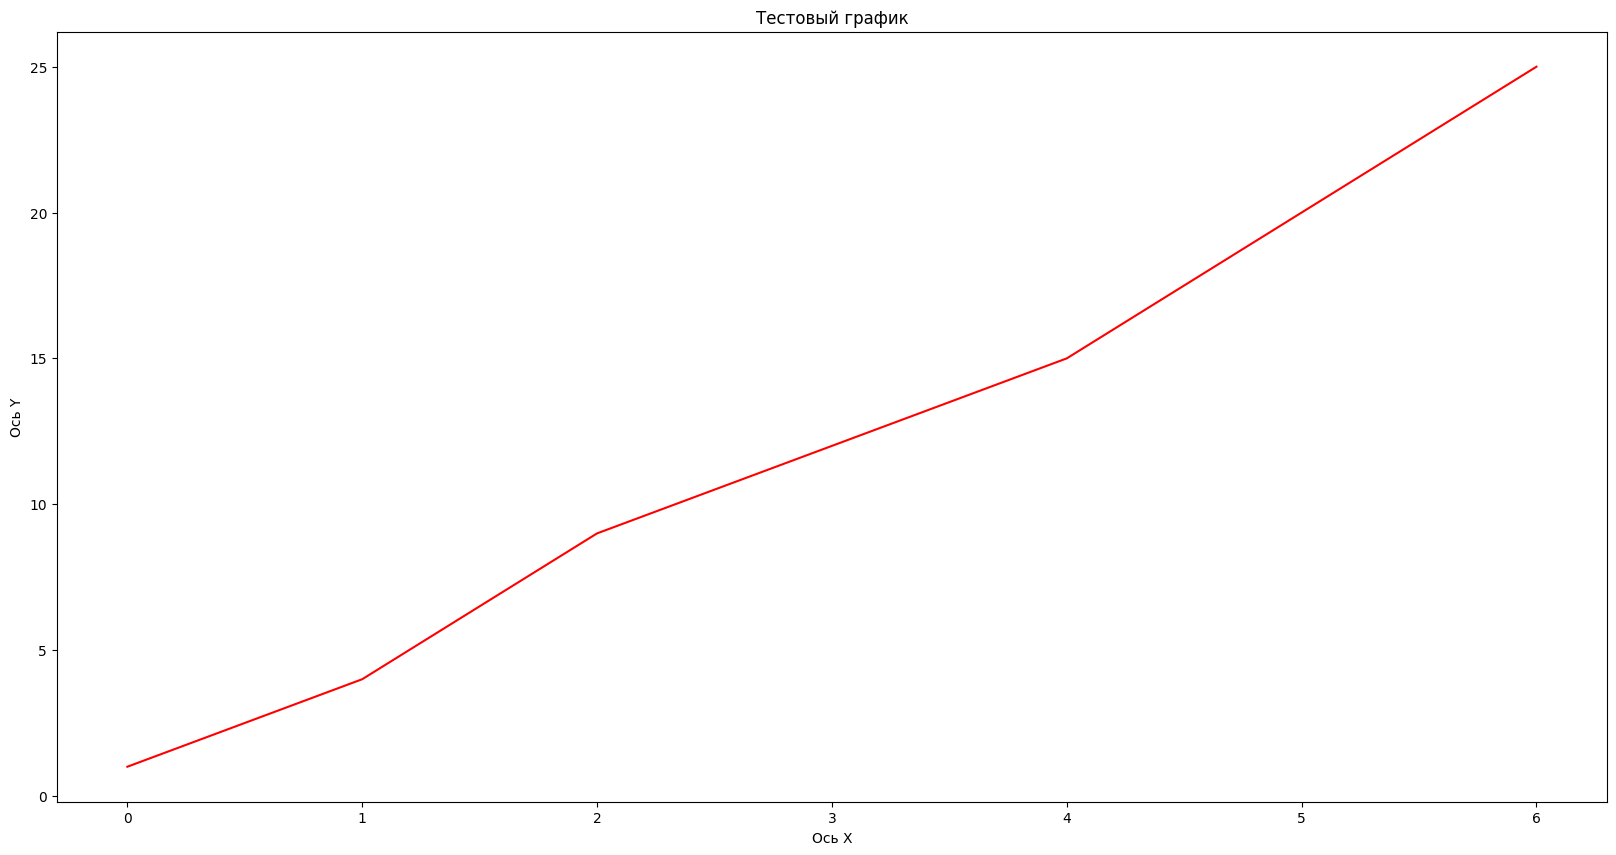

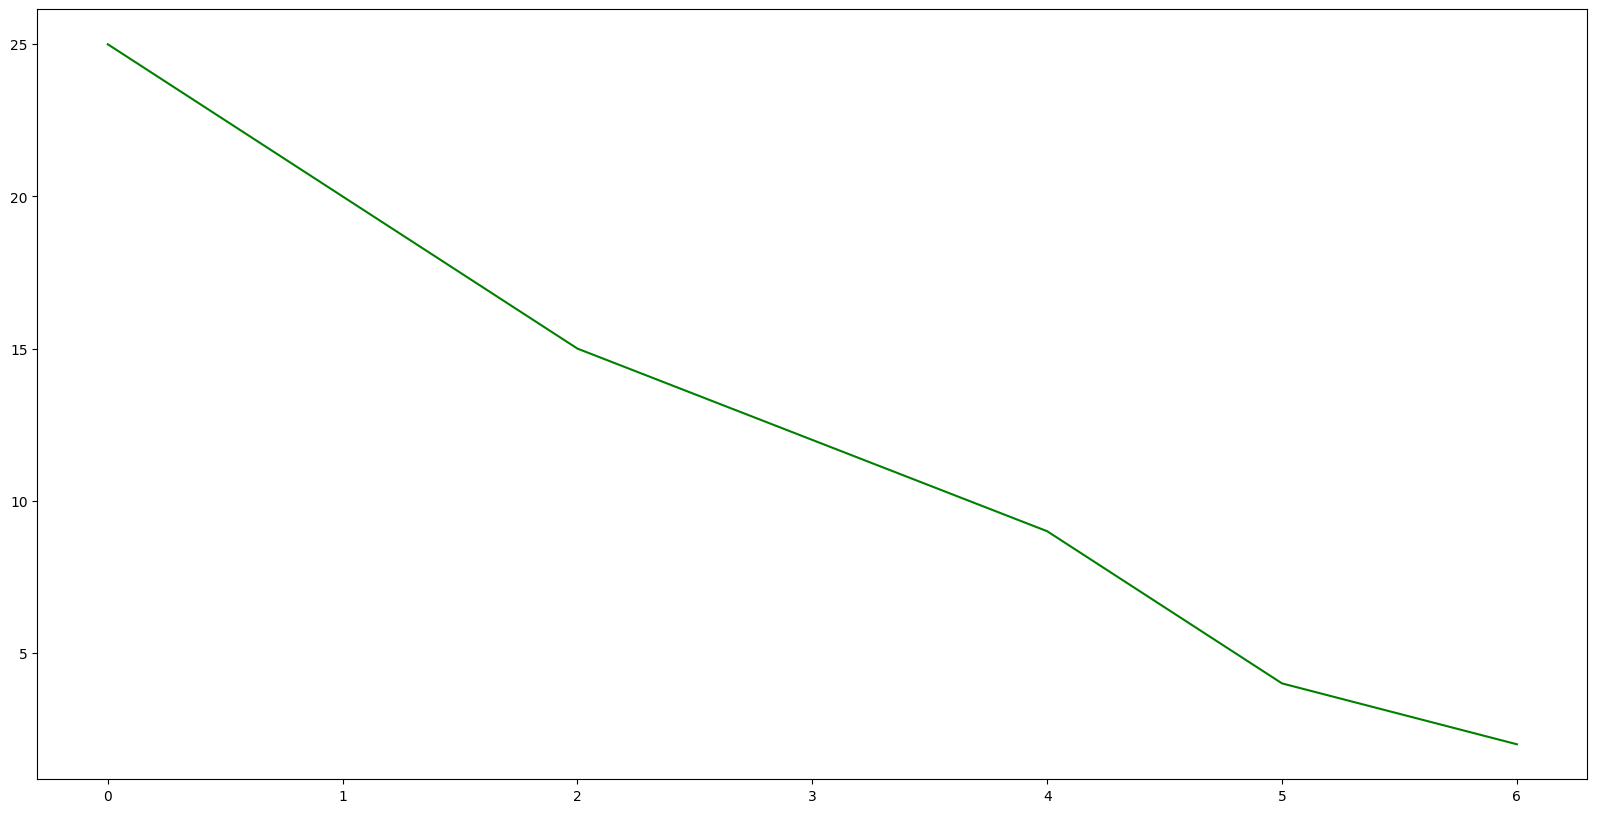

In [ ]:
plt.plot([1, 4, 9, 12, 15, 20, 25], color = 'red')
plt.title ("Тестовый график")
plt.xlabel("Ось Х")
plt.ylabel("Ось Y")

plt.show()
plt.plot([25, 20, 15, 12, 9, 4, 2], color = 'green')
##plt.legend(["тест1","тест2"])
plt.show()